In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import OneHotEncoder
import math
from PIL import Image

rink = Image.open('rink-zones_large.jpg')
rink.thumbnail((200, 85), Image.ANTIALIAS)

In [2]:
def calculate_strength(df):
    Skaters = []
    for i in range(len(df)):
        state = '?'
        if df.loc[i,'Team'] == df.loc[i,'Home Team']:
            state = str(df.loc[i,'Home Team Skaters']) + "v" + str(df.loc[i,'Away Team Skaters'])
        elif df.loc[i,'Team'] == df.loc[i,'Away Team']:
            state = str(df.loc[i,'Away Team Skaters']) + "v" + str(df.loc[i,'Home Team Skaters'])
        Skaters.append(state)
    return Skaters

def calculate_strength_general(df):
    states = []
    for i in range(len(df)):
        state = '?'
        if df.loc[i,'Team'] == df.loc[i,'Home Team']:
            if df.loc[i,'Home Team Skaters'] == df.loc[i,'Away Team Skaters']:
                state = "even strength"
            elif df.loc[i,'Home Team Skaters'] > df.loc[i,'Away Team Skaters']:
                state = "power play"
            else:
                state = "shorthanded"
        elif df.loc[i,'Team'] == df.loc[i,'Away Team']:
            if df.loc[i,'Away Team Skaters'] == df.loc[i,'Home Team Skaters']:
                state = "even strength"
            elif df.loc[i,'Away Team Skaters'] > df.loc[i,'Home Team Skaters']:
                state = "power play"
            else:
                state = "shorthanded"
        states.append(state)
    return states

In [3]:
def get_shot_dist_and_angle(df):
    Shot_distance = []
    Shot_angle = []
    for i in range(len(df)):
        sd = np.nan
        sa = np.nan
        if df.loc[i,'Event'] in ['Shot', 'Goal']:
            sd = ((df.loc[i,'X Coordinate'] - 189) ** 2 + (df.loc[i,'Y Coordinate'] - 42.5) ** 2)**0.5
            sa = np.arctan(abs(df.loc[i,'Y Coordinate'] - 42.5)/(189 - (df.loc[i,'X Coordinate'])))
            sa = sa * 180/np.pi
        Shot_distance.append(sd)
        Shot_angle.append(sa)
    df['Shot Angle'] = Shot_angle
    df['Shot Distance'] = Shot_distance
    return df

In [4]:
#xG features
#Shot Distance 'Shot Distance'
#Time since last event* 'Time Since Last'
#Shot Type 'Detail 1'
#Shot Angle 'Shot Angle'
#East/west mvmt from last event* 'Lateral Since Last'
#Rebound angle* ?
#Other team skaters* 'Opp Team Skaters'
#Is powerplay*
#print(df.columns)
#df.loc[df.Event == 'Shot']['Detail 1']

def find_diff_bt_events(df):
    elapsed_since_last = [np.nan]
    east_west_since_last = [np.nan]
    last_event = [np.nan]
    for j in range(1,len(df)):
        i = j-1
        time_delta = int(df.loc[i,'Clock'].split(':')[0]) * 60 + int(df.loc[i,'Clock'].split(':')[1]) \
                         - int(df.loc[j,'Clock'].split(':')[0]) * 60 - int(df.loc[j,'Clock'].split(':')[1])
        elapsed_since_last.append(time_delta)
        lateral_delta = abs(df.loc[i,'Y Coordinate'] - df.loc[j,'Y Coordinate'])
        last_event.append(df.loc[i,'Event'])
        east_west_since_last.append(lateral_delta)
    return elapsed_since_last, east_west_since_last, last_event

def find_time_bt_events(df):
    elapsed_since_last = [np.nan]
    for j in range(1,len(df)):
        i = j-1
        time_delta = int(df.loc[i,'Clock'].split(':')[0]) * 60 + int(df.loc[i,'Clock'].split(':')[1]) \
                         - int(df.loc[j,'Clock'].split(':')[0]) * 60 - int(df.loc[j,'Clock'].split(':')[1])
        elapsed_since_last.append(time_delta)
    return elapsed_since_last

def find_opp_team_skaters(df):
    opp_team_skaters = []
    for i in range(len(df)):
        if df.loc[i,'Team'] == df.loc[i,'Away Team']:
            opp_team_skaters = df.loc[i,'Home Team Skaters']
        else:
            opp_team_skaters = df.loc[i,'Away Team Skaters']
    return opp_team_skaters

In [5]:
def get_xG_inputs(df):
    #Use functions to get data about the prior event
    time_d, lat_d, lasts = find_diff_bt_events(df)
    df['Time Since Last'] = time_d
    df['Last Event Type'] = lasts
    df['Lateral Since Last'] = lat_d
    df['Opp Team Skaters'] = find_opp_team_skaters(df)
    #More categorical variables and target
    df['Is Powerplay'] = [1 if x == 'power play' else 0 for x in df['Strength'].tolist()]
    df['Is Goal'] = [1 if x == 'Goal' else 0 for x in df['Event'].tolist()]
    #Trim to only shots
    shot_df = df.loc[df.Event.isin(["Goal", "Shot"])]
    indices = shot_df.index.tolist()
    shot_df.reset_index(inplace=True)
    #Categorical variables for prior event type
    enc = OneHotEncoder()
    x = enc.fit_transform(shot_df[['Last Event Type']])
    headers = (enc.categories_)
    headers = (['Last Was ' + str(x) for x in headers[0]])
    rows = enc.transform(shot_df[['Last Event Type']]).toarray()
    cat_data = pd.DataFrame(data = rows, columns = headers)
    cat_data
    for h in headers:
        shot_df[h] = cat_data[h]
    #Categorical variables for shot type
    enc2 = OneHotEncoder()
    x = enc2.fit_transform(shot_df[['Detail 1']])
    headers = (enc2.categories_)
    headers = ([str(x) for x in headers[0]])
    rows = enc2.transform(shot_df[['Detail 1']]).toarray()
    cat_data = pd.DataFrame(data = rows, columns = headers)
    cat_data
    for h in headers:
        shot_df[h] = cat_data[h]
    #Select and return xG model inputs and target
    inputs = shot_df.reset_index()[['X Coordinate', 'Y Coordinate', 'Shot Angle', 'Shot Distance', 'Time Since Last',
       'Lateral Since Last', 'Opp Team Skaters', 'Is Powerplay', \
       #'Last Was Play', <- omitted
       'Last Was Puck Recovery', \
       'Last Was Shot', 'Last Was Takeaway', 'Last Was Zone Entry', \
       'Deflection', 'Fan', 'Slapshot', 'Snapshot', 'Wrap Around', \
       #'Wristshot' <- omitted
       ]]

    labels = shot_df.reset_index()['Is Goal']
    return inputs, labels, indices

In [6]:
def train_xg_model(x,y):
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    kf.get_n_splits(x)
    clf = LogisticRegressionCV(#Cs=list(np.power(10.0, np.arange(-10, 10))), penalty = 'l2', \
                               scoring='roc_auc', cv=kf,random_state=0,max_iter=10000,fit_intercept=True \
                               ,solver='newton-cg', tol=10)
    clf.fit(x, y)
    #print(clf.score(inputs,labels))
    coefs = pd.DataFrame(list(zip(np.array(x.columns),clf.coef_.T)), \
                   columns = ['Variable','Coef']).sort_values(['Coef'], ascending=False)
    print(coefs)
    return clf

In [7]:
df_women = pd.read_csv('https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/hackathon_womens.csv')
df_scouting = pd.read_csv('https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/hackathon_scouting.csv')
df_nwhl = pd.read_csv('https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/hackathon_nwhl.csv')

In [8]:
len(df_women)

24002

In [5]:
# Fit xG model and apply to dataframe
dfw = get_shot_dist_and_angle(df_women)
dfw['Skaters'] = calculate_strength(dfw)
dfw['Strength'] = calculate_strength_general(dfw)

w_inp, w_lab, w_ind = get_xG_inputs(dfw)

xgw = train_xg_model(w_inp, w_lab)

w_pred = xgw.predict_proba(inputs)[:,1]
dfw['xG'] = [np.nan for i in range(len(dfw))]
for i in range(len(w_ind)):
    dfw.loc[w_ind[i],'xG'] = w_pred[i]
    
dfw.loc[dfw.Event == 'Shot']

In [86]:
df = get_shot_dist_and_angle(df_scouting)
df['Skaters'] = calculate_strength(df)
df['Strength'] = calculate_strength_general(df)
time_d, lat_d, lasts = find_diff_bt_events(df)
df['Time Since Last'] = time_d
df['Last Event Type'] = lasts
df['Lateral Since Last'] = lat_d
df['Opp Team Skaters'] = find_opp_team_skaters(df)
df['Is Powerplay'] = [1 if x == 'power play' else 0 for x in df['Strength'].tolist()]
df['Is Goal'] = [1 if x == 'Goal' else 0 for x in df['Event'].tolist()]

C:\Users\devli\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


In [249]:
#df.loc[df.Event == 'Shot'][['Event','Detail 1', 'Detail 2', 'Detail 3']]
shot_df = df.loc[df.Event.isin(["Goal", "Shot"])]
shot_df.reset_index(inplace=True)
shot_df

,index,game_date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,...,Shot Angle,Shot Distance,Skaters,Strength,Time Since Last,Lateral Since Last,Opp Team Skaters,Is Powerplay,Last Event Type,Is Goal
0,16,2019-09-20,Erie Otters,Sudbury Wolves,1,19:26,5,5,0,0,...,50.389312,18.821530,5v5,even strength,1.0,3.0,5,0,Puck Recovery,0
1,19,2019-09-20,Erie Otters,Sudbury Wolves,1,19:21,5,5,0,0,...,26.565051,61.491869,5v5,even strength,1.0,7.0,5,0,Play,0
2,20,2019-09-20,Erie Otters,Sudbury Wolves,1,19:21,5,5,0,0,...,29.357754,27.536340,5v5,even strength,0.0,14.0,5,0,Shot,0
3,34,2019-09-20,Erie Otters,Sudbury Wolves,1,19:01,5,5,0,0,...,59.184294,33.185087,5v5,even strength,2.0,10.0,5,0,Zone Entry,0
4,87,2019-09-20,Erie Otters,Sudbury Wolves,1,17:17,5,5,0,0,...,32.182632,68.529191,5v5,even strength,2.0,12.0,5,0,Play,0
5,88,2019-09-20,Erie Otters,Sudbury Wolves,1,17:17,5,5,0,0,...,45.784825,25.811819,5v5,even strength,0.0,18.0,5,0,Shot,0
6,99,2019-09-20,Erie Otters,Sudbury Wolves,1,16:37,5,5,0,0,...,14.036243,43.292609,5v5,even strength,0.0,19.0,5,0,Puck Recovery,0
7,157,2019-09-20,Erie Otters,Sudbury Wolves,1,14:53,5,5,0,0,...,10.388858,30.500000,5v5,even strength,2.0,10.0,5,0,Takeaway,0
8,171,2019-09-20,Erie Otters,Sudbury Wolves,1,14:30,5,5,0,0,...,11.842076,31.674122,5v5,even strength,0.0,18.0,5,0,Play,0
9,178,2019-09-20,Erie Otters,Sudbury Wolves,1,14:20,5,5,0,0,...,25.407718,22.141590,5v5,even strength,1.0,16.0,5,0,Play,0


In [250]:
enc = OneHotEncoder()
x = enc.fit_transform(shot_df[['Last Event Type']])
headers = (enc.categories_)
headers = (['Last Was ' + str(x) for x in headers[0]])
rows = enc.transform(shot_df[['Last Event Type']]).toarray()
cat_data = pd.DataFrame(data = rows, columns = headers)
cat_data
for h in headers:
    shot_df[h] = cat_data[h]

C:\Users\devli\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [251]:
enc2 = OneHotEncoder()
x = enc2.fit_transform(shot_df[['Detail 1']])
headers = (enc2.categories_)
headers = ([str(x) for x in headers[0]])
print(headers)
rows = enc2.transform(shot_df[['Detail 1']]).toarray()
cat_data = pd.DataFrame(data = rows, columns = headers)
cat_data
for h in headers:
    shot_df[h] = cat_data[h]

['Deflection', 'Fan', 'Slapshot', 'Snapshot', 'Wrap Around', 'Wristshot']


C:\Users\devli\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [254]:
#print(shot_df.columns)

inputs = shot_df.reset_index()[['X Coordinate', 'Y Coordinate', 'Shot Angle', 'Shot Distance', 'Time Since Last',
       'Lateral Since Last', 'Opp Team Skaters', 'Is Powerplay', \
       #'Last Was Play', 
       'Last Was Puck Recovery', \
       'Last Was Shot', 'Last Was Takeaway', 'Last Was Zone Entry', \
       'Deflection', 'Fan', 'Slapshot', 'Snapshot', 'Wrap Around', \
       #'Wristshot'
       ]]

labels = shot_df.reset_index()['Is Goal']

In [274]:
kf = KFold(n_splits=10, shuffle=True, random_state=0)
kf.get_n_splits(inputs)
clf = LogisticRegressionCV(#Cs=list(np.power(10.0, np.arange(-10, 10))), penalty = 'l2', \
                           scoring='roc_auc', cv=kf,random_state=0,max_iter=10000,fit_intercept=True \
                           ,solver='newton-cg', tol=10)

clf.fit(inputs, labels)

clf.score(inputs,labels)


C:\Users\devli\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:2257: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


0.8034145057130745

In [275]:
coefs = pd.DataFrame(list(zip(np.array(inputs.columns),clf.coef_.T)), \
                   columns = ['Variable','Coef']).sort_values(['Coef'], ascending=False)
coefs

,Variable,Coef
6,Opp Team Skaters,[1.1468830661702243]
11,Last Was Zone Entry,[0.2919851098331798]
16,Wrap Around,[0.09366102769126829]
7,Is Powerplay,[0.050582804762355216]
15,Snapshot,[0.020756802108215348]
5,Lateral Since Last,[0.010831692023335398]
1,Y Coordinate,[0.005421305992865776]
2,Shot Angle,[-0.005734198313343764]
0,X Coordinate,[-0.03562724854175665]
3,Shot Distance,[-0.09051523456154775]


C:\Users\devli\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


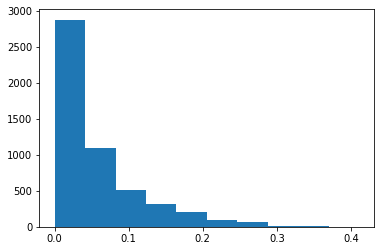

In [278]:
plt.hist(clf.predict_proba(inputs)[:,1])

shot_df['xG'] = clf.predict_proba(inputs)[:,1]

C:\Users\devli\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


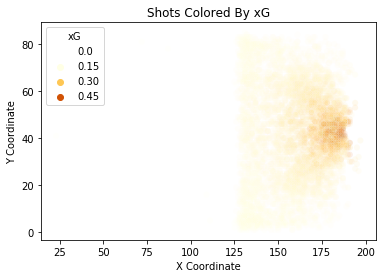

In [308]:
fig, ax = plt.subplots()
shot_df['xG'] = shot_df.xG.round(3)
sns.scatterplot(x='X Coordinate', y='Y Coordinate', data=shot_df, alpha=.1, hue='xG', ax=ax, palette = 'YlOrBr')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, [x[:4] for x in labels[1:]], title = 'xG')
ax.set_title('Shots Colored By xG')
plt.show()

In [8]:
w_pred = xgw.predict_proba(inputs)[:,1]
dfw['xG'] = [np.nan for i in range(len(dfw))]
for i in range(len(w_ind)):
    dfw.loc[w_ind[i],'xG'] = w_pred[i]
    
dfw.loc[dfw.Event == 'Shot']['Detail 1']

NameError: name 'xgw' is not defined

In [72]:
def summarize_oz_stints(df):
    stint_dict = {'start_ind':[],'end_ind':[],'shots':[],'passes':[],'duration':[]}
    for i in range(len(df)):
        start_index = -1
        start_time = -1
        end_time = "0:00"
        end_index = -1
        pass_count = 0
        sat_count = 0
        if df.loc[i,'Event'] == 'Zone Entry':
            start_index = i
            start_time = df.loc[i,'Clock']
            for j in range(start_index,len(df)):
                if df.loc[j,'Team'] != df.loc[i,'Team'] or df.loc[j,'Event'] == 'Faceoff Win':
                    end_index = j - 1
                    end_time = df.loc[j, 'Clock']
                    break
                elif df.loc[j,'Event'] == 'Goal':
                    end_index = j
                    end_time = df.loc[j, 'Clock']
                    sat_count += 1
                    break
                elif df.loc[j,'Event'] == 'Shot':
                    sat_count += 1
                elif df.loc[j,'Event'] == 'Play':
                    pass_count += 1
            duration = int(start_time.split(':')[0]) * 60 + int(start_time.split(':')[1]) - int(end_time.split(':')[0]) * 60 - int(end_time.split(':')[1])
        if end_index - start_index > 0:
            stint_dict['start_ind'].append(start_index)
            stint_dict['end_ind'].append(end_index)
            stint_dict['shots'].append(sat_count)
            stint_dict['passes'].append(pass_count)
            stint_dict['duration'].append(duration) 
    return stint_dict

In [73]:
es_df = df.loc[df.Skaters == '5v5'].reset_index()
es_df

,index,game_date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,...,Detail 2,Detail 3,Detail 4,Player 2,X Coordinate 2,Y Coordinate 2,Shot Angle,Shot Distance,Skaters,Strength
0,0,2019-09-20,Erie Otters,Sudbury Wolves,1,20:00,5,5,0,0,...,NaN,NaN,NaN,Connor Lockhart,NaN,NaN,NaN,NaN,5v5,even strength
1,1,2019-09-20,Erie Otters,Sudbury Wolves,1,19:58,5,5,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5v5,even strength
2,2,2019-09-20,Erie Otters,Sudbury Wolves,1,19:53,5,5,0,0,...,NaN,NaN,NaN,Blake Murray,74.0,35.0,NaN,NaN,5v5,even strength
3,3,2019-09-20,Erie Otters,Sudbury Wolves,1,19:52,5,5,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5v5,even strength
4,4,2019-09-20,Erie Otters,Sudbury Wolves,1,19:51,5,5,0,0,...,NaN,NaN,NaN,Connor Lockhart,94.0,46.0,NaN,NaN,5v5,even strength
5,5,2019-09-20,Erie Otters,Sudbury Wolves,1,19:48,5,5,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5v5,even strength
6,6,2019-09-20,Erie Otters,Sudbury Wolves,1,19:45,5,5,0,0,...,NaN,NaN,NaN,Blake Murray,29.0,2.0,NaN,NaN,5v5,even strength
7,7,2019-09-20,Erie Otters,Sudbury Wolves,1,19:39,5,5,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5v5,even strength
8,8,2019-09-20,Erie Otters,Sudbury Wolves,1,19:38,5,5,0,0,...,NaN,NaN,NaN,Owen Gilhula,82.0,54.0,NaN,NaN,5v5,even strength
9,9,2019-09-20,Erie Otters,Sudbury Wolves,1,19:36,5,5,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5v5,even strength


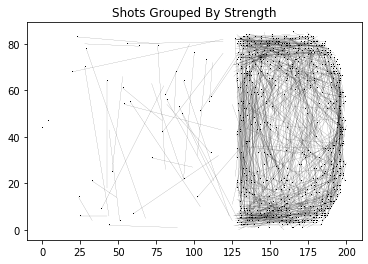

In [82]:
stint_df = pd.DataFrame.from_dict(summarize_oz_stints(es_df))
mult_shot_stints = stint_df.loc[stint_df.shots > 1].reset_index()

len(mult_shot_stints)
fig, ax = plt.subplots()
for i in range(len(mult_shot_stints)):
    for n in range(mult_shot_stints.loc[i,'start_ind'],mult_shot_stints.loc[i,'end_ind']):
        if es_df.loc[n,'Event'] == 'Play':
            x1 = es_df.loc[n,'X Coordinate']
            x2 = es_df.loc[n,'X Coordinate 2']
            y1 = es_df.loc[n,'Y Coordinate']
            y2 = es_df.loc[n,'Y Coordinate 2']
            plt.plot([x1,x2],[y1,y2],'k,-', markevery=2,lw=0.1)
#sns.scatterplot(x='X Coordinate', y='Y Coordinate', data=mult_shot_stints.loc[mult_shot_stints.Event == 'Play'], alpha=.1, hue='Strength', ax=ax)
ax.set_title('Shots Grouped By Strength')
plt.show()

In [50]:
df.loc[4200:4214,:][['Clock','Event','Detail 1', 'X Coordinate', "Y Coordinate"]]

,Clock,Event,Detail 1,X Coordinate,Y Coordinate
4200,5:39,Zone Entry,Played,125,57
4201,5:38,Play,Direct,151,78
4202,5:37,Shot,Wristshot,177,54
4203,5:36,Puck Recovery,NaN,192,47
4204,5:34,Play,Direct,191,22
4205,5:31,Play,Direct,134,38
4206,5:29,Play,Direct,145,32
4207,5:28,Incomplete Play,Direct,165,64
4208,5:26,Puck Recovery,NaN,145,3
4209,5:24,Play,Direct,144,7


In [85]:
stint_df.corr()

,start_ind,end_ind,shots,passes,duration
start_ind,1.000000,1.000000,0.005525,0.008323,-0.009122
end_ind,1.000000,1.000000,0.005611,0.008453,-0.009109
shots,0.005525,0.005611,1.000000,0.335134,0.007704
passes,0.008323,0.008453,0.335134,1.000000,0.074647
duration,-0.009122,-0.009109,0.007704,0.074647,1.000000


In [55]:
dfw_entries = df_scouting.loc[df_scouting.Event == 'Zone Entry']
dfw_entries

,game_date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,Team,...,Event,X Coordinate,Y Coordinate,Detail 1,Detail 2,Detail 3,Detail 4,Player 2,X Coordinate 2,Y Coordinate 2
10,2019-09-20,Erie Otters,Sudbury Wolves,1,19:36,5,5,0,0,Sudbury Wolves,...,Zone Entry,102,71,Dumped,NaN,NaN,NaN,Kurtis Henry,NaN,NaN
25,2019-09-20,Erie Otters,Sudbury Wolves,1,19:15,5,5,0,0,Erie Otters,...,Zone Entry,125,55,Carried,NaN,NaN,NaN,Liam Ross,NaN,NaN
33,2019-09-20,Erie Otters,Sudbury Wolves,1,19:03,5,5,0,0,Erie Otters,...,Zone Entry,124,81,Carried,NaN,NaN,NaN,Liam Ross,NaN,NaN
46,2019-09-20,Erie Otters,Sudbury Wolves,1,18:40,5,5,0,0,Erie Otters,...,Zone Entry,124,5,Carried,NaN,NaN,NaN,Jack Thompson,NaN,NaN
53,2019-09-20,Erie Otters,Sudbury Wolves,1,18:32,5,5,0,0,Erie Otters,...,Zone Entry,97,29,Dumped,NaN,NaN,NaN,Isaak Phillips,NaN,NaN
57,2019-09-20,Erie Otters,Sudbury Wolves,1,18:25,5,5,0,0,Sudbury Wolves,...,Zone Entry,101,36,Dumped,NaN,NaN,NaN,Jack Duff,NaN,NaN
70,2019-09-20,Erie Otters,Sudbury Wolves,1,17:58,5,5,0,0,Erie Otters,...,Zone Entry,94,61,Dumped,NaN,NaN,NaN,Nathan Ribau,NaN,NaN
76,2019-09-20,Erie Otters,Sudbury Wolves,1,17:42,5,5,0,0,Erie Otters,...,Zone Entry,110,80,Dumped,NaN,NaN,NaN,Nathan Ribau,NaN,NaN
114,2019-09-20,Erie Otters,Sudbury Wolves,1,16:14,5,5,0,0,Sudbury Wolves,...,Zone Entry,112,10,Dumped,NaN,NaN,NaN,Jamie Drysdale,NaN,NaN
119,2019-09-20,Erie Otters,Sudbury Wolves,1,16:06,5,5,0,0,Sudbury Wolves,...,Zone Entry,95,37,Dumped,NaN,NaN,NaN,Jamie Drysdale,NaN,NaN


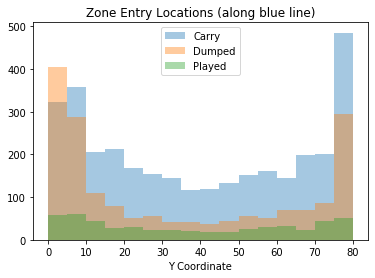

In [56]:
fig, ax = plt.subplots()
sns.distplot(dfw_entries.loc[dfw_entries['Detail 1'] == 'Carried']['Y Coordinate'],bins = range(0,85,5), ax=ax, hist=True, kde=False, label='Carry')
sns.distplot(dfw_entries.loc[dfw_entries['Detail 1'] == 'Dumped']['Y Coordinate'],bins = range(0,85,5),ax=ax, hist=True, kde=False, label='Dumped')
sns.distplot(dfw_entries.loc[dfw_entries['Detail 1'] == 'Played']['Y Coordinate'],bins = range(0,85,5),ax=ax, hist=True, kde=False, label='Played')
ax.set_title('Zone Entry Locations (along blue line)')
ax.legend()
plt.show()

In [8]:
def shot_feature_adder(df):
    nwhl = df
    dfw = get_shot_dist_and_angle(nwhl)
    dfw['Skaters'] = calculate_strength(dfw)
    dfw['Strength'] = calculate_strength_general(dfw)
    w_inp, w_lab, w_ind = get_xG_inputs(dfw)
    xgw = train_xg_model(w_inp, w_lab)
    w_pred = xgw.predict_proba(w_inp)[:,1]
    dfw['xG'] = [np.nan for i in range(len(dfw))]
    for i in range(len(w_ind)):
        dfw.loc[w_ind[i],'xG'] = w_pred[i]
    return dfw

In [9]:
def clocktime(clock):
    time = int(clock.split(':')[0]) * 60 + int(clock.split(':')[1])
    return time

def dist(a,b):
    runtot = 0
    for i in range(len(a)):
        runtot += (a[i] - b[i]) ** 2
    return runtot ** 0.5

In [10]:
scouting = shot_feature_adder(df_scouting)
scouting['Is Point'] = [1 if (x > 125 and x < 135) else 0 for x in scouting['X Coordinate']]
scouting['Is Mid'] = [1 if (y > 20 and y < 65) else 0 for y in scouting['Y Coordinate']]
scouting['xg_pm_45'] = [np.nan for i in range(len(scouting))]
scouting['c_pm_45'] = [np.nan for i in range(len(scouting))]

for i in range(len(scouting)):
    if scouting.loc[i,'Event'] in ['Play', 'Incomplete Play']:
        xg_pm = 0
        c_pm = 0
        start_time = clocktime(scouting.loc[i,'Clock'])
        start_team = scouting.loc[i,'Team']
        for j in range(i,len(scouting)):
            curr_time = clocktime(scouting.loc[j,'Clock'])
            if curr_time < start_time - 45 or curr_time > start_time:
                break
            if scouting.loc[j,'Event'] in ['Shot', 'Goal']:
                if scouting.loc[j,'Team'] == start_team:
                    xg_pm += scouting.loc[j,'xG']
                    c_pm += 1
                else:
                    xg_pm += scouting.loc[j,'xG'] * -1
                    c_pm += -1
            if scouting.loc[j,'Event'] == 'Goal':
                break
        scouting.loc[i,'xg_pm_45'] = xg_pm
        scouting.loc[i,'c_pm_45'] = c_pm
    else:
        pass

C:\Users\devli\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
C:\Users\devli\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\devli\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                  Variable                     Coef
6         Opp Team Skaters     [1.1468830661702243]
11     Last Was Zone Entry     [0.2919851098331798]
16             Wrap Around    [0.09366102769126829]
7             Is Powerplay   [0.050582804762355216]
15                Snapshot   [0.020756802108215348]
5       Lateral Since Last   [0.010831692023335398]
1             Y Coordinate   [0.005421305992865776]
2               Shot Angle  [-0.005734198313343764]
0             X Coordinate   [-0.03562724854175665]
3            Shot Distance   [-0.09051523456154775]
14                Slapshot   [-0.28077977659521514]
10       Last Was Takeaway    [-0.2866617689125305]
9            Last Was Shot    [-0.3141588433941187]
4          Time Since Last    [-0.4069592282343983]
8   Last Was Puck Recovery    [-0.5034047542719211]
12              Deflection     [-1.042800005166116]
13                     Fan    [-1.4087432741587422]


In [12]:
pass_features = scouting.loc[scouting.Event.isin(['Play', 'Incomplete Play'])]
pass_features['successful'] = [1 if x == 'Play' else 0 for x in pass_features['Event'].tolist()]
pass_features = pass_features.loc[pass_features['Is Powerplay'] != 1]
pass_features['origin'] = pass_features[['X Coordinate', 'Y Coordinate']].values.tolist()
pass_features['destination'] = pass_features[['X Coordinate 2', 'Y Coordinate 2']].values.tolist()
pass_features

C:\Users\devli\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,game_date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,Team,...,Is Powerplay,Is Goal,xG,Is Point,Is Mid,xg_pm_45,c_pm_45,successful,origin,destination
2,2019-09-20,Erie Otters,Sudbury Wolves,1,19:53,5,5,0,0,Sudbury Wolves,...,0,0,NaN,0,1,0.094811,3.0,0,"[45, 49]","[74.0, 35.0]"
4,2019-09-20,Erie Otters,Sudbury Wolves,1,19:51,5,5,0,0,Erie Otters,...,0,0,NaN,0,1,-0.094811,-3.0,0,"[82, 49]","[94.0, 46.0]"
6,2019-09-20,Erie Otters,Sudbury Wolves,1,19:45,5,5,0,0,Sudbury Wolves,...,0,0,NaN,0,1,0.066311,2.0,1,"[6, 60]","[29.0, 2.0]"
8,2019-09-20,Erie Otters,Sudbury Wolves,1,19:38,5,5,0,0,Sudbury Wolves,...,0,0,NaN,0,1,0.066311,2.0,1,"[82, 50]","[82.0, 54.0]"
12,2019-09-20,Erie Otters,Sudbury Wolves,1,19:32,5,5,0,0,Erie Otters,...,0,0,NaN,0,0,-0.066311,-2.0,1,"[9, 74]","[4.0, 29.0]"
13,2019-09-20,Erie Otters,Sudbury Wolves,1,19:30,5,5,0,0,Erie Otters,...,0,0,NaN,0,1,-0.066311,-2.0,1,"[4, 29]","[24.0, 2.0]"
14,2019-09-20,Erie Otters,Sudbury Wolves,1,19:27,5,5,0,0,Erie Otters,...,0,0,NaN,0,0,-0.066311,-2.0,0,"[24, 2]","[26.0, 43.0]"
18,2019-09-20,Erie Otters,Sudbury Wolves,1,19:22,5,5,0,0,Sudbury Wolves,...,0,0,NaN,0,0,0.012953,1.0,1,"[187, 77]","[133.0, 79.0]"
22,2019-09-20,Erie Otters,Sudbury Wolves,1,19:20,5,5,0,0,Erie Otters,...,0,0,NaN,0,1,0.028500,1.0,1,"[23, 44]","[42.0, 61.0]"
23,2019-09-20,Erie Otters,Sudbury Wolves,1,19:18,5,5,0,0,Erie Otters,...,0,0,NaN,0,0,0.028500,1.0,1,"[51, 75]","[77.0, 82.0]"


In [14]:
passes = pass_features.loc[pass_features['X Coordinate'] > 125].reset_index(drop = False)

nearest = []
nearest_d = []

for i in range(len(passes)):
    dists = []
    ix = passes.loc[i,'X Coordinate']
    for j in range(len(passes)):
        o_dist = dist(passes.loc[i,'origin'], passes.loc[j,'origin'])
        d_dist = dist(passes.loc[i,'destination'], passes.loc[j,'destination'])
        comb_dist = o_dist + d_dist
        dists.append(comb_dist)
    nearest_d.append(sorted(dists)[:100])
    nearest.append(sorted(range(len(dists)), key=lambda k: dists[k])[:100])
    if i % 100 == 0:
        print(str(i) + " out of " + str(len(passes)))
    
passes['nearest'] = nearest
passes['nearest_d'] = nearest_d
passes.to_csv('test.csv')

0 out of 9580
100 out of 9580
200 out of 9580
300 out of 9580
400 out of 9580
500 out of 9580
600 out of 9580
700 out of 9580
800 out of 9580
900 out of 9580
1000 out of 9580
1100 out of 9580
1200 out of 9580
1300 out of 9580
1400 out of 9580
1500 out of 9580
1600 out of 9580
1700 out of 9580
1800 out of 9580
1900 out of 9580
2000 out of 9580
2100 out of 9580
2200 out of 9580
2300 out of 9580
2400 out of 9580
2500 out of 9580
2600 out of 9580
2700 out of 9580
2800 out of 9580
2900 out of 9580
3000 out of 9580
3100 out of 9580
3200 out of 9580
3300 out of 9580
3400 out of 9580
3500 out of 9580
3600 out of 9580
3700 out of 9580
3800 out of 9580
3900 out of 9580
4000 out of 9580
4100 out of 9580
4200 out of 9580
4300 out of 9580
4400 out of 9580
4500 out of 9580
4600 out of 9580
4700 out of 9580
4800 out of 9580
4900 out of 9580
5000 out of 9580
5100 out of 9580
5200 out of 9580
5300 out of 9580
5400 out of 9580
5500 out of 9580
5600 out of 9580
5700 out of 9580
5800 out of 9580
5900 out 

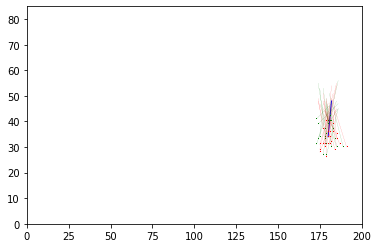

['3247',
 ' 8636',
 ' 3804',
 ' 2589',
 ' 7403',
 ' 2631',
 ' 2397',
 ' 9130',
 ' 7398',
 ' 5937',
 ' 5857',
 ' 5509',
 ' 4523',
 ' 2935',
 ' 3703',
 ' 8424',
 ' 3522',
 ' 5051',
 ' 9022',
 ' 3756',
 ' 4174',
 ' 2423',
 ' 8260',
 ' 743',
 ' 740',
 ' 7856',
 ' 2007',
 ' 5204',
 ' 7699',
 ' 2827',
 ' 7147',
 ' 4248',
 ' 3674',
 ' 3354',
 ' 7811',
 ' 7090',
 ' 2043',
 ' 2402',
 ' 3421',
 ' 4194',
 ' 6175',
 ' 665',
 ' 1797',
 ' 5324',
 ' 8229',
 ' 808',
 ' 6026',
 ' 7079',
 ' 1886',
 ' 419',
 ' 5916',
 ' 8753',
 ' 6694',
 ' 4368',
 ' 8044',
 ' 7292',
 ' 3914',
 ' 5510',
 ' 567',
 ' 4554',
 ' 6469',
 ' 5116',
 ' 3387',
 ' 2420',
 ' 8637',
 ' 857',
 ' 1985',
 ' 1908',
 ' 6753',
 ' 423',
 ' 568',
 ' 6343',
 ' 4447',
 ' 7659',
 ' 3237',
 ' 2637',
 ' 1031',
 ' 5856',
 ' 2191',
 ' 8105',
 ' 2394',
 ' 5522',
 ' 8088',
 ' 7589',
 ' 7825',
 ' 443',
 ' 4021',
 ' 5867',
 ' 1953',
 ' 8271',
 ' 8759',
 ' 6610',
 ' 947',
 ' 8347',
 ' 3793',
 ' 7274',
 ' 2735',
 ' 5691',
 ' 4120',
 ' 2140']

In [166]:
fig, ax = plt.subplots()
plt.xlim(0,200)
plt.ylim(0,85)
index_to_test = dpi[69]
for i in passes.loc[index_to_test,'nearest'][:50]:
    i = int(i.strip(' '))
    x1 = passes.loc[i,'X Coordinate']
    x2 = passes.loc[i,'X Coordinate 2']
    y1 = passes.loc[i,'Y Coordinate']
    y2 = passes.loc[i,'Y Coordinate 2']
    if i == index_to_test:
        plt.plot([x1,x2],[y1,y2],'b,-', markevery=2,lw=1)
    elif passes.loc[i,'Event'] == 'Play':
        plt.plot([x1,x2],[y1,y2],'g,-', markevery=2,lw=0.1)
    else:
        plt.plot([x1,x2],[y1,y2],'r,-', markevery=2,lw=0.1)
plt.show()

passes.loc[3247,'nearest']

In [163]:
#compute expected completion percentage/ avg xG
passes = pd.read_csv('test.csv', index_col = 0)
passes['nearest'] = passes.nearest.str.strip('[').str.strip(']').str.split(',')
passes['nearest_d'] = passes.nearest_d.str.strip('[').str.strip(']').str.split(',')
xG = []
completion_rate = []
for index_to_test in range(len(passes)):
    temp_completion_rate = []
    tempXG = []
    j = 0
    while (float(passes.loc[index_to_test,'nearest_d'][j].strip(' ')) < 35 and j < 50) or j < 5:
        i = int(passes.loc[index_to_test,'nearest'][j].strip(' '))
        if i == index_to_test:
            pass
        elif passes.loc[i,'Event'] == 'Play':
            tempXG.append(passes.loc[i, 'xg_pm_45'])
            temp_completion_rate.append(1)
        else:
            tempXG.append(passes.loc[i, 'xg_pm_45'])
            temp_completion_rate.append(0)
        j += 1
    xG.append(sum(tempXG)/len(tempXG))
    completion_rate.append(sum(temp_completion_rate)/len(temp_completion_rate))

    
passes['similarPassAvgXG'] = xG
passes['expectedCompletionRate'] = completion_rate
#float(passes.loc[1,'nearest_d'][j].strip(' '))

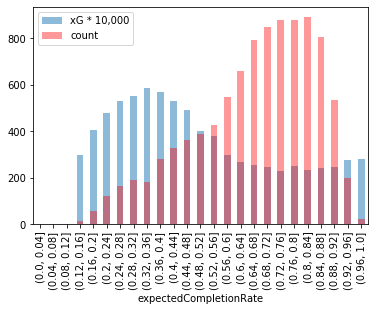

,expectedCompletionRate,similarPassAvgXG,count
0,"(0.0, 0.04]",NaN,0
1,"(0.04, 0.08]",NaN,0
2,"(0.08, 0.12]",NaN,0
3,"(0.12, 0.16]",296.377032,15
4,"(0.16, 0.2]",404.537410,56
5,"(0.2, 0.24]",479.568289,122
6,"(0.24, 0.28]",530.738950,165
7,"(0.28, 0.32]",551.613680,192
8,"(0.32, 0.36]",585.499957,184
9,"(0.36, 0.4]",568.995638,281


In [164]:
from pandasql import sqldf
bins = [x/25 for x in range(26)]
p_mean = passes.groupby(pd.cut(passes.expectedCompletionRate, bins)).mean().iloc[:,:-1]
p_count = passes.groupby(pd.cut(passes.expectedCompletionRate, bins)).count().iloc[:,:-1]
p_mean['count'] = p_count['index']
pass_summary = p_mean[['similarPassAvgXG', 'count']].reset_index(drop=False)
pass_summary

fig, ax = plt.subplots()
pass_summary['similarPassAvgXG'] = pass_summary['similarPassAvgXG'] * 10000
pass_summary.plot.bar('expectedCompletionRate','similarPassAvgXG', alpha=.5, ax=ax, label = 'xG * 10,000')
pass_summary.plot.bar('expectedCompletionRate','count', alpha=.4, ax=ax, color='r')
plt.show()
pass_summary

In [88]:
dangerousPasses = passes.sort_values(by='similarPassAvgXG', ascending=False)[:100]
dpi = dangerousPasses.index.tolist()

In [124]:
X = point_events[['Event', 'Detail 1', 'Y Coordinate', 'Opp Team Skaters']].reset_index(drop=True)
X['Detail 1'].fillna('default', inplace=True)
X['Event_Combo'] = X['Event'] + " " + X['Detail 1']
y = point_events['xg_pm_45']

In [125]:
encoder = OneHotEncoder()
x = encoder.fit_transform(X[['Event']])
headers = (encoder.categories_)
rows = encoder.transform(X[['Event']]).toarray()
cat_data = pd.DataFrame(data = rows, columns = headers)
cat_data
for h in headers:
    X[h] = cat_data[h]

C:\Users\devli\Anaconda3\lib\site-packages\seaborn\distributions.py:423: UserWarning: The following kwargs were not used by contour: 'weights'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


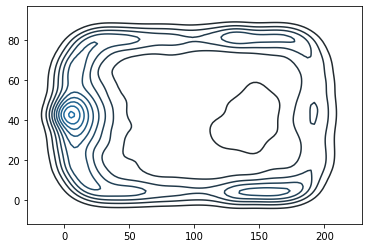

In [173]:
recoveries = scouting.loc[scouting.Event == 'Puck Recovery'][['X Coordinate', 'Y Coordinate',

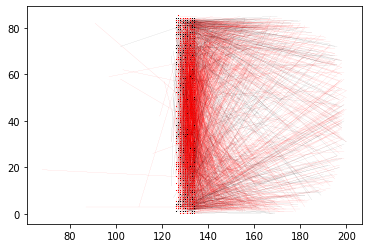

In [197]:
for i in scouting[(scouting.Event.isin(['Incomplete Play', 'Play'])) & (scouting['Is Point'] == 1)].index.tolist():
    x1 = scouting.loc[i,'X Coordinate']
    x2 = scouting.loc[i,'X Coordinate 2']
    y1 = scouting.loc[i,'Y Coordinate']
    y2 = scouting.loc[i,'Y Coordinate 2']
    if scouting.loc[i,'Event'] == 'Incomplete Play':
        plt.plot([x1,x2],[y1,y2],'r,-', markevery=2,lw=0.05)
    else:
        plt.plot([x1,x2],[y1,y2],'g,-', markevery=2,lw=0.05)

In [ ]:
#TODO:
#Investigate xG and completion rate of various point passes